### RQ 1

#### Read in ARTS datasets

In [1]:
import pickle
import pandas as pd
from matcher import get_mapping_of_LF_and_dims
import math
from scipy import stats

resources get initialised


In [2]:
def load_ARTS_data(dims):
    X = []
    scores = []
    labels = []

    if dims == 94:
        path_X = f"/workspace/datasets/ARTS/arts94-1249_labels.pkl"        
        path_y = f"/workspace/datasets/ARTS/gpt-4-1106-preview-94_scores.pkl"      
        path_label = f"/workspace/datasets/ARTS/ARTS_94_DF.pkl"      
    if dims == 300:
        path_X = f"/workspace/datasets/ARTS/arts300-1249_labels.pkl"        
        path_y = f"/workspace/datasets/ARTS/gpt-4-1106-preview-300_scores.pkl"      
        path_label = f"/workspace/datasets/ARTS/ARTS_300_DF.pkl"      
    if dims == 3000:
        path_X = f"/workspace/datasets/ARTS/arts3000-1249_labels.pkl"        
        path_y = f"/workspace/datasets/ARTS/gpt-4-1106-preview-3000_scores.pkl"  
        path_label = f"/workspace/datasets/ARTS/ARTS_3000_DF.pkl"      

    X_labels = pickle.load(open(path_X, "rb"))
    cur_scores = pickle.load(open(path_y, "rb"))
    cur_labels = pickle.load(open(path_label, 'rb'))

    for i, r in cur_labels.iterrows():
        labels.append(r['Label'])

    X = X_labels

    for i in range(len(X)):
        scores.append(cur_scores[i][0])

    return X, scores, labels

In [3]:
arts94_X, arts94_scores, arts94_labels = load_ARTS_data(94)
arts300_X, arts300_scores, arts300_labels = load_ARTS_data(300)
arts3000_X, arts3000_scores, arts3000_labels = load_ARTS_data(3000)

#### Prepare structures containing information on relation of parametrizations, interpretations, features, categories

In [4]:
dims_to_names, names_to_dims, name_to_thresless, name_to_category, name_to_feature = get_mapping_of_LF_and_dims()

In [5]:
names_to_comp_simp = {}

df_cs = pd.DataFrame(arts3000_X)

for dim in range(len(arts3000_X[0])):
    cnts = df_cs[dim].value_counts()

    name = dims_to_names[dim][0]

    if 0 in cnts:
        names_to_comp_simp[name] = 'simp'
    else:
        if 1 in cnts:
            names_to_comp_simp[name] = 'complex'
        else:
            if 'NOT_SIMPLE' in name:
                names_to_comp_simp[name] = 'complex'
            else:
                if 'SIMPLE' in name:
                    names_to_comp_simp[name] = 'simp'
                else:
                    if 'label=1' in name:
                        names_to_comp_simp[name] = 'complex'
                    else:
                        if 'label=0' in name:
                            names_to_comp_simp[name] = 'simp'
                        else:
                            if dim == 228 or dim == 229 or dim == 230 or dim == 555 or dim == 556 or dim == 557 or dim == 558 or dim == 559 or dim == 560 or dim == 561 or dim == 562 or \
                                dim == 563 or dim == 564 or dim == 565 or dim == 566 or dim == 567 or dim == 568 or dim == 569 or dim == 570 or dim == 571 or dim == 571 or dim == 572 or \
                                dim == 573 or dim == 574 or dim == 990:
                                names_to_comp_simp[name] = 'simp'
                            else:
                                if dim == 985 or dim == 991 or dim == 992 or dim == 993 or dim == 994 or dim == 995 or dim == 1001 or dim == 1002 or dim == 1004 or dim == 1005:
                                    names_to_comp_simp[name] = 'complex'
                                else:
                                    print(dim)
                                    print(name)

cnt_feat = {}
cnt_cat = {}

comp_name_to_feature = {}
simp_name_to_feature = {}

for name in name_to_feature:
    feat = name_to_feature[name]
    if names_to_comp_simp[name] == 'simp':
        simp_name_to_feature[name] = feat
    
        if feat + '_simp' not in cnt_feat:
            cnt_feat[feat + '_simp'] = 1
        else:
            cnt_feat[feat + '_simp'] += 1
    else:
        comp_name_to_feature[name] = feat

        if feat + '_complex' not in cnt_feat:
            cnt_feat[feat + '_complex'] = 1
        else:
            cnt_feat[feat + '_complex'] += 1

comp_name_to_cat = {}
simp_name_to_cat = {}

for name in name_to_category:
    cat = name_to_category[name]
    if names_to_comp_simp[name] == 'simp':
        comp_name_to_cat[name] = cat

        if cat + '_simp' not in cnt_cat:
            cnt_cat[cat + '_simp'] = 1
        else:
            cnt_cat[cat + '_simp'] += 1
    else:
        simp_name_to_cat[name] = cat

        if cat + '_complex' not in cnt_cat:
            cnt_cat[cat + '_complex'] = 1
        else:
            cnt_cat[cat + '_complex'] += 1

#### Remap values in X so 1 indicates a characteristic has been encountered and 0 means abstain

In [6]:
def remap(ds):
    arts_X_remapped = []

    for entry in ds:
        vals = []

        for n in entry:
            if n == 0: # simple
                vals.append(1)
            else:
                if n == -1: # abstain 
                    vals.append(0)
                else:
                    if n == 1: # complex
                        vals.append(1)

        arts_X_remapped.append(vals)
        
    return arts_X_remapped

In [7]:
arts3000_X_remapped = remap(arts3000_X)
arts300_X_remapped = remap(arts300_X)
arts94_X_remapped = remap(arts94_X)

#### Create structures containing summed up values for dimensions per representarion

In [8]:
dim_to_name_simp = {}
dim_to_name_comp = {}

In [9]:
def fill_ds_for_arts(ds):
    para_to_dim_simp = {}
    para_to_dim_comp = {}

    inter_to_dim_simp = {}
    inter_to_dim_comp = {}

    feat_to_dim_simp = {}
    feat_to_dim_comp = {}
    cat_to_dim_simp = {}
    cat_to_dim_comp = {}

    inter_simp = set()
    inter_comp = set()

    for i in range(len(ds[0])):
        name = dims_to_names[i][0].strip()
        stance = names_to_comp_simp[name]

        if stance == 'simp':
            if not name in para_to_dim_simp:
                dim_to_name_simp[len(para_to_dim_simp)] = name
                para_to_dim_simp[name] = len(para_to_dim_simp)

            inter = name_to_thresless[name].strip()
            if inter not in inter_to_dim_simp:
                inter_to_dim_simp[inter] = len(inter_to_dim_simp)
                inter_simp.add(inter)

            feat = name_to_feature[name].strip()
            if feat not in feat_to_dim_simp:
                feat_to_dim_simp[feat] = len(feat_to_dim_simp)
            
            cate = name_to_category[name].strip()
            if cate not in cat_to_dim_simp:
                cat_to_dim_simp[cate] = len(cat_to_dim_simp)
        else: 
            if not name in para_to_dim_comp:
                dim_to_name_comp[len(para_to_dim_comp)] = name
                para_to_dim_comp[name] = len(para_to_dim_comp)


            inter = name_to_thresless[name].strip()
            if inter not in inter_to_dim_comp:
                inter_to_dim_comp[inter] = len(inter_to_dim_comp)
                inter_comp.add(inter)

            feat = name_to_feature[name].strip()
            if feat not in feat_to_dim_comp:
                feat_to_dim_comp[feat] = len(feat_to_dim_comp)
            
            cate = name_to_category[name].strip()
            if cate not in cat_to_dim_comp:
                cat_to_dim_comp[cate] = len(cat_to_dim_comp)

    all_para_s = []
    all_para_c = []

    all_int_s = [] 
    all_int_c = [] 

    all_feat_s = [] 
    all_feat_c = []

    all_cat_s = [] 
    all_cat_c = [] 

    for i in range(len(ds)):
        all_para_s.append([0] * len(simp_name_to_feature))
        all_para_c.append([0] * len(comp_name_to_feature))

        temp = []
        for i in range(len(inter_simp)):
            temp.append([])
        all_int_s.append(temp)
        
        temp = []
        for i in range(len(inter_comp)):
            temp.append([])
        all_int_c.append(temp)

        temp = []
        for i in range(37):
            temp.append([])
        all_feat_s.append(temp)   

        temp = []
        for i in range(34):
            temp.append([])
        all_feat_c.append(temp)    

        temp = []
        for i in range(4):
            temp.append([])
        all_cat_s.append(temp)
        all_cat_c.append(temp)


    # fill structures
    for i in range(len(ds)):
        for j in range(len(ds[i])):
            c_val = ds[i][j]

            c_name = dims_to_names[j][0]
            c_stance = names_to_comp_simp[c_name]

            if c_stance == 'simp':
                c_para = para_to_dim_simp[c_name]
                all_para_s[i][c_para] = c_val
                c_inter = inter_to_dim_simp[name_to_thresless[c_name]]
                all_int_s[i][c_inter].append(c_val)
                c_feat = feat_to_dim_simp[name_to_feature[c_name]]
                all_feat_s[i][c_feat].append(c_val)
                c_cat = cat_to_dim_simp[name_to_category[c_name]]
                all_cat_s[i][c_cat].append(c_val)
            else:
                c_para = para_to_dim_comp[c_name]
                all_para_c[i][c_para] = c_val
                c_inter = inter_to_dim_comp[name_to_thresless[c_name]]
                all_int_c[i][c_inter].append(c_val)
                c_feat = feat_to_dim_comp[name_to_feature[c_name]]
                all_feat_c[i][c_feat].append(c_val)
                c_cat = cat_to_dim_comp[name_to_category[c_name]]
                all_cat_c[i][c_cat].append(c_val)


    for i in range(len(ds)):
        for j in range(len(inter_simp)):
            all_int_s[i][j] = sum(all_int_s[i][j])/len(all_int_s[i][j])

        for j in range(len(inter_comp)):
            all_int_c[i][j] = sum(all_int_c[i][j])/len(all_int_c[i][j])

        for j in range(37):
            tmp = sum(all_feat_s[i][j])/len(all_feat_s[i][j])
            all_feat_s[i][j] = tmp

        for j in range(34):
            if '[' in str(all_feat_c[i][j]):
                all_feat_c[i][j] = sum(all_feat_c[i][j]) / len(all_feat_c[i][j])
            
        for j in range(4):
            all_cat_s[i][j] = sum(all_cat_s[i][j])/len(all_cat_s[i][j])

            if '[' in str(all_cat_c[i][j]):
                all_cat_c[i][j] = sum(all_cat_c[i][j]) / len(all_cat_c[i][j])
            
    all_para_s = pd.DataFrame(all_para_s)
    all_para_c = pd.DataFrame(all_para_c)
    all_inter_s = pd.DataFrame(all_int_s)
    all_inter_c = pd.DataFrame(all_int_c)
    all_feat_s = pd.DataFrame(all_feat_s)
    all_feat_c = pd.DataFrame(all_feat_c)
    all_cat_s = pd.DataFrame(all_cat_s)
    all_cat_c = pd.DataFrame(all_cat_c)

    return all_para_s, all_para_c, all_inter_s, all_inter_c, all_feat_s, all_feat_c, all_cat_s, all_cat_c, feat_to_dim_simp, feat_to_dim_comp, cat_to_dim_simp, cat_to_dim_comp

In [10]:
all_para_s_94, all_para_c_94, all_inter_s_94, all_inter_c_94, all_feat_s_94, all_feat_c_94, all_cat_s_94, all_cat_c_94, feat_to_dim_simp_94, feat_to_dim_comp_94, cat_to_dim_simp_94, cat_to_dim_comp_94 = fill_ds_for_arts(arts94_X_remapped)
all_para_s_300, all_para_c_300, all_inter_s_300, all_inter_c_300, all_feat_s_300, all_feat_c_300, all_cat_s_300, all_cat_c_300, feat_to_dim_simp_300, feat_to_dim_comp_300, cat_to_dim_simp_300, cat_to_dim_comp_300 = fill_ds_for_arts(arts300_X_remapped)
all_para_s_3000, all_para_c_3000, all_inter_s_3000, all_inter_c_3000, all_feat_s_3000, all_feat_c_3000, all_cat_s_3000, all_cat_c_3000, feat_to_dim_simp_3000, feat_to_dim_comp_3000, cat_to_dim_simp_3000, cat_to_dim_comp_3000 = fill_ds_for_arts(arts3000_X_remapped)

#### Identify dimensions to be kept (based on "high" correlation of ARTS score and different dimensions from vector representation)

In [11]:
def calc_cors(arts_ds_s, arts_ds_c, scores_ds):
        
    final_cor_s = []

    for i in arts_ds_s.columns:
        cor = stats.pearsonr(arts_ds_s[i], scores_ds)[0]
        if not math.isnan(cor):
            final_cor_s.append((cor, i))
        else:
            final_cor_s.append((0, i))

    final_cor_c = []

    for i in arts_ds_c.columns:
        cor = stats.pearsonr(arts_ds_c[i], scores_ds)[0]
        if not math.isnan(cor):
            final_cor_c.append((cor, i))
        else:
            final_cor_c.append((0, i))
    
    return final_cor_s, final_cor_c

In [12]:
final_cor_s_reduce_3000, final_cor_c_reduce_3000 = calc_cors(all_para_s_3000, all_para_c_3000, arts3000_scores)

kept_names = []
kept_names_s = []
kept_dim_s = []

for tuple in final_cor_s_reduce_3000:
    if tuple[0] <= -0.25:
        kept_dim_s.append(tuple[1])
        kept_names_s.append(dim_to_name_simp[tuple[1]])
        kept_names.append(dim_to_name_simp[tuple[1]])

kept_names_c = []
kept_dim_c = []

for tuple in final_cor_c_reduce_3000:
    if tuple[0] >= 0.25:
        kept_dim_c.append(tuple[1])
        kept_names_c.append(dim_to_name_comp[tuple[1]])
        kept_names.append(dim_to_name_comp[tuple[1]])

/usr/local/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


#### Correlations for all datasets -> importance of dimensions

In [13]:
final_cor_s_94, final_cor_c_94 = calc_cors(all_para_s_94, all_para_c_94, arts94_scores)
final_cor_s_300, final_cor_c_300 = calc_cors(all_para_s_300, all_para_c_300, arts300_scores)
final_cor_s_3000, final_cor_c_3000 = calc_cors(all_para_s_3000, all_para_c_3000, arts3000_scores)

#### Reduce data structures containing correlations to only those where ARTS_3000 had good enough correlation of indication of characteristics with ARTS scores

In [14]:
def reduce_corr_to_kept_dims(final_cor_s, final_cor_c):
    kept_cor_s = []
    for t in final_cor_s:
        if t[1] in kept_dim_s:
            kept_cor_s.append(t[0])

    kept_cor_c = []
    for t in final_cor_c:
        if t[1] in kept_dim_c:
            kept_cor_c.append(t[0])
    
    return kept_cor_s, kept_cor_c

In [15]:
kept_s_94, kept_c_94 = reduce_corr_to_kept_dims(final_cor_s_94, final_cor_c_94)
kept_s_300, kept_c_300 = reduce_corr_to_kept_dims(final_cor_s_300, final_cor_c_300)
kept_s_3000, kept_c_3000 = reduce_corr_to_kept_dims(final_cor_s_3000, final_cor_c_3000)

In [16]:
def map_name_to_dim(red_dim_names):
    sim_para_2_dim = {}
    com_para_2_dim = {}
    
    sim_inter_2_dim = {}
    sim_inter = {}
    com_inter_2_dim = {}
    com_inter = {}

    sim_feat_2_dim = {}
    sim_feat = {}
    com_feat_2_dim = {}
    com_feat = {}

    sim_cat_2_dim = {}
    sim_cat = {}
    com_cat_2_dim = {}
    com_cat = {}

    for i in range(len(red_dim_names)):
        name = red_dim_names[i].strip()
        inter = name_to_thresless[name]
        feat = name_to_feature[name]
        cat = name_to_category[name]

        stance = names_to_comp_simp[name]

        if stance == 'simp':
            sim_para_2_dim[name] = len(sim_para_2_dim)

            if inter in sim_inter:
                sim_inter_2_dim[name] = sim_inter[inter]
            else:
                c_len = len(sim_inter)
                sim_inter_2_dim[name] = c_len
                sim_inter[inter] = c_len
                
            if feat in sim_feat:
                sim_feat_2_dim[name] = sim_feat[feat]
            else:
                c_len = len(sim_feat)
                sim_feat_2_dim[name] = c_len
                sim_feat[feat] = c_len

            if cat in sim_cat:
                sim_cat_2_dim[name] = sim_cat[cat]
            else:
                c_len = len(sim_cat)
                sim_cat_2_dim[name] = c_len
                sim_cat[cat] = c_len
        else:
            com_para_2_dim[name] = len(com_para_2_dim)

            if inter in com_inter:
                com_inter_2_dim[name] = com_inter[inter]
            else:
                c_len = len(com_inter)
                com_inter_2_dim[name] = c_len
                com_inter[inter] = c_len
                
            if feat in com_feat:
                com_feat_2_dim[name] = com_feat[feat]
            else:
                c_len = len(com_feat)
                com_feat_2_dim[name] = c_len
                com_feat[feat] = c_len

            if cat in com_cat:
                com_cat_2_dim[name] = com_cat[cat]
            else:
                c_len = len(com_cat)
                com_cat_2_dim[name] = c_len
                com_cat[cat] = c_len

    return sim_para_2_dim, com_para_2_dim, sim_inter_2_dim, com_inter_2_dim, sim_feat_2_dim, com_feat_2_dim, sim_cat_2_dim, com_cat_2_dim

In [17]:
sim_para_2_dim, com_para_2_dim, sim_inter_2_dim, com_inter_2_dim, sim_feat_2_dim, com_feat_2_dim, sim_cat_2_dim, com_cat_2_dim = map_name_to_dim(kept_names)

In [18]:
def fill_ds_for_datasets(kept_s, kept_c):
    max_inter_s = 0
    max_inter_c = 0

    for e in sim_inter_2_dim:
        if sim_inter_2_dim[e] > max_inter_s:
            max_inter_s = sim_inter_2_dim[e]
    for e in com_inter_2_dim:
        if com_inter_2_dim[e] > max_inter_c:
            max_inter_c = com_inter_2_dim[e]

    max_feat_s = 0
    max_feat_c = 0

    for e in sim_feat_2_dim:
        if sim_feat_2_dim[e] > max_feat_s:
            max_feat_s = sim_feat_2_dim[e]
    for e in com_feat_2_dim:
        if com_feat_2_dim[e] > max_feat_c:
            max_feat_c = com_feat_2_dim[e]

    max_cat_s = 0
    max_cat_c = 0

    for e in sim_cat_2_dim:
        if sim_cat_2_dim[e] > max_cat_s:
            max_cat_s = sim_cat_2_dim[e]
    for e in com_cat_2_dim:
        if com_cat_2_dim[e] > max_cat_c:
            max_cat_c = com_cat_2_dim[e]

    all_int_s = []
    all_int_c = []

    all_feat_s = []
    all_feat_c = []

    all_cat_s = []
    all_cat_c = []
    
    for i in range(max_inter_s + 1):
        all_int_s.append([])
    
    for i in range(max_inter_c + 1):
        all_int_c.append([])

    for i in range(max_feat_s + 1):
        all_feat_s.append([])

    for i in range(max_feat_c + 1):
        all_feat_c.append([])

    for i in range(max_cat_c + 1):
        all_cat_s.append([])
        all_cat_c.append([])

    for i in range(len(kept_s)):
        c_name = kept_names_s[i]
        c_val = kept_s[i]

        c_inter = sim_inter_2_dim[c_name]
        all_int_s[c_inter].append(c_val)
        c_feat = sim_feat_2_dim[c_name]
        all_feat_s[c_feat].append(c_val)
        c_cat = sim_cat_2_dim[c_name]
        all_cat_s[c_cat].append(c_val)


    for i in range(len(kept_c)):
        c_name = kept_names_c[i]
        c_val = kept_c[i]

        c_inter = com_inter_2_dim[c_name]
        all_int_c[c_inter].append(c_val)
        c_feat = com_feat_2_dim[c_name]
        all_feat_c[c_feat].append(c_val)
        c_cat = com_cat_2_dim[c_name]
        all_cat_c[c_cat].append(c_val)

    for j in range((max_inter_s + 1)):
        all_int_s[j] = sum(all_int_s[j])/len(all_int_s[j])

    for j in range((max_inter_c + 1)):
        all_int_c[j] = sum(all_int_c[j])/len(all_int_c[j])

    for j in range((max_feat_s + 1)):
        all_feat_s[j] = sum(all_feat_s[j])/len(all_feat_s[j])

    for j in range((max_feat_c + 1)):
        if len(all_feat_c[j]) > 0:
            all_feat_c[j] = sum(all_feat_c[j]) / len(all_feat_c[j])
        else:
            all_feat_c[j] = 0
            
    for j in range(max_cat_s + 1):
        if '[' in str(all_cat_s[j]):
            all_cat_s[j] = sum(all_cat_s[j])/len(all_cat_s[j])

    for j in range(max_cat_c + 1):

        if '[' in str(all_cat_c[j]):
            all_cat_c[j] = sum(all_cat_c[j]) / len(all_cat_c[j])

    all_para_s = pd.DataFrame(kept_s)
    all_para_c = pd.DataFrame(kept_c)
    all_inter_s = pd.DataFrame(all_int_s)
    all_inter_c = pd.DataFrame(all_int_c)
    all_feat_s = pd.DataFrame(all_feat_s)
    all_feat_c = pd.DataFrame(all_feat_c)
    all_cat_s = pd.DataFrame(all_cat_s)
    all_cat_c = pd.DataFrame(all_cat_c)

    return all_para_s, all_para_c, all_inter_s, all_inter_c, all_feat_s, all_feat_c, all_cat_s, all_cat_c

In [19]:
all_para_s_94, all_para_c_94, all_inter_s_94, all_inter_c_94, all_feat_s_94, all_feat_c_94, all_cat_s_94, all_cat_c_94 = fill_ds_for_datasets(kept_s_94, kept_c_94)
all_para_s_300, all_para_c_300, all_inter_s_300, all_inter_c_300, all_feat_s_300, all_feat_c_300, all_cat_s_300, all_cat_c_300 = fill_ds_for_datasets(kept_s_300, kept_c_300)
all_para_s_3000, all_para_c_3000, all_inter_s_3000, all_inter_c_3000, all_feat_s_3000, all_feat_c_3000, all_cat_s_3000, all_cat_c_3000 = fill_ds_for_datasets(kept_s_3000, kept_c_3000)

#### Visualization of importance of dimensions from different levels

In [20]:
import math
import seaborn as sns

In [21]:
def get_data(simple, rep):
    if simple:
        if rep == 'para':
            curr_94 = all_para_s_94
            curr_300 = all_para_s_300
            curr_3000 = all_para_s_3000

            title = 'Correlation of Parametrisations (simple)'
            sns.set(rc = {'figure.figsize':(5,15)})

        if rep == 'inter':
            curr_94 = all_inter_s_94
            curr_300 = all_inter_s_300
            curr_3000 = all_inter_s_3000

            title = 'Correlation of Interpretations (simple)'
            sns.set(rc = {'figure.figsize':(5,2.5)})

        if rep == 'feat':
            curr_94 = all_feat_s_94
            curr_300 = all_feat_s_300
            curr_3000 = all_feat_s_3000

            title = 'Correlation of Features (simple)'

            sns.set(rc = {'figure.figsize':(5,2.5)})

        if rep == 'cat':
            curr_94 = all_cat_s_94
            curr_300 = all_cat_s_300
            curr_3000 = all_cat_s_3000

            title = 'Correlation of Categories (simple)'             

            sns.set(rc = {'figure.figsize':(5,1)})
    else:
        if rep == 'para':
            curr_94 = all_para_c_94
            curr_300 = all_para_c_300
            curr_3000 = all_para_c_3000

            title = 'Correlation of Parametrisations (complex)'

            sns.set(rc = {'figure.figsize':(5,15)})

        if rep == 'inter':
            curr_94 = all_inter_c_94
            curr_300 = all_inter_c_300
            curr_3000 = all_inter_c_3000

            title = 'Correlation of Interpretations (complex)'

            sns.set(rc = {'figure.figsize':(5,2.5)})

        if rep == 'feat':
            curr_94 = all_feat_c_94
            curr_300 = all_feat_c_300
            curr_3000 = all_feat_c_3000

            title = 'Correlation of Features (complex)'

            sns.set(rc = {'figure.figsize':(5,2.5)})
        if rep == 'cat':
            curr_94 = all_cat_c_94
            curr_300 = all_cat_c_300
            curr_3000 = all_cat_c_3000

            title = 'Correlation of Categories (complex)'             

            sns.set(rc = {'figure.figsize':(5,1)})  


    return curr_94, curr_300, curr_3000, title

Text(0.5, 1.0, 'Correlation of Parametrisations (complex)')

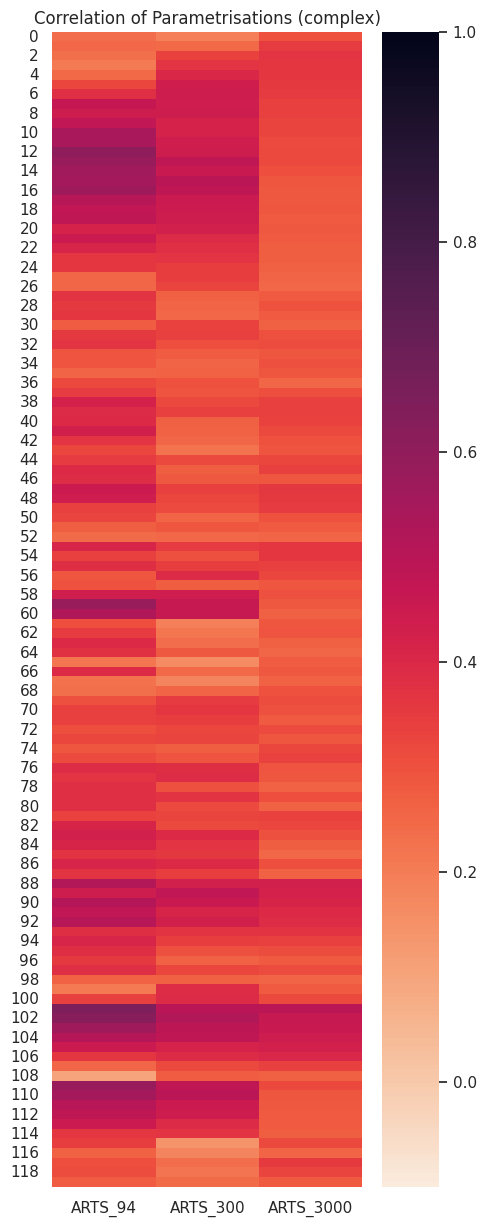

In [28]:
simple = False
rep = 'para'
cors94, cors300, cors3000, title = get_data(simple, rep)

para_df = pd.DataFrame({'ARTS_94': cors94[0], 'ARTS_300': cors300[0], 'ARTS_3000': cors3000[0]})

sns.heatmap(para_df, vmin=1, vmax=0, cmap='rocket_r').set_title(title)
#sns.heatmap(para_df, vmin=-1, vmax=0).set_title(title) 

#### Identification of Param/Inter/Feat with highest importance

In [23]:
def find_most_important(simple, rep, n):
    if simple:
        if rep == 'para':
            mapping = sim_para_2_dim
        if rep == 'inter':
            mapping = sim_inter_2_dim
        if rep == 'feat':
            mapping = sim_feat_2_dim
    else:
        if rep == 'para':
            mapping = com_para_2_dim
        if rep == 'inter':
            mapping = com_inter_2_dim
        if rep == 'feat':
            mapping = com_feat_2_dim

    cors94, cors300, cors3000, title = get_data(simple, rep)
    para_df = pd.DataFrame({'ARTS_94': cors94[0], 'ARTS_300': cors300[0], 'ARTS_3000': cors3000[0]})
    sets = {'ARTS_94': set(), 'ARTS_300': set(), 'ARTS_3000': set()}

    for setting in para_df.columns:
        if not simple:
            rows = para_df.nlargest(n, setting)
        else:
            rows = para_df.nsmallest(n, setting)

        for i, r in rows.iterrows():
            for entry in mapping:
                if mapping[entry] == i:
                    if rep == 'para':
                        sets[setting].add(entry)
                    if rep == 'inter':
                        sets[setting].add(name_to_thresless[entry])
                    if rep == 'feat':
                        sets[setting].add(name_to_feature[entry])

    intersect = sets['ARTS_94'].intersection(sets['ARTS_300']).intersection(sets['ARTS_3000'])

    return sets, intersect

In [24]:
simple = False
rep = 'feat' # needs to be in 'para', 'inter', 'feat'
n = 5

sets, intersect = find_most_important(simple, rep, n)

print(str(intersect)[2:-2].replace("'", '').replace('_', '$\_$'))
print(str(sets['ARTS_94'].difference(intersect))[2:-2].replace("'", '').replace('_', '$\_$'))
print(str(sets['ARTS_300'].difference(intersect))[2:-2].replace("'", '').replace('_', '$\_$'))
print(str(sets['ARTS_3000'].difference(intersect))[2:-2].replace("'", '').replace('_', '$\_$'))

low Flesch-Kincaid Grade Level Index, few words per sentence, short sentences
average lexical richness, few infrequent words
average lexical richness, high imageability
few noun phrases, low age of acquisition
